## Goal

E-commerce websites often transact huge amounts of money. And whenever a huge amount of money is moved, there is a high risk of users performing fraudulent activities, e.g. using stolen credit cards, doing money laundry, et. Machine Learning really excels at identifying fraudulent activities. Any website where you put your credit card information has a risk team in charge of avoiding frauds via machine learning. The goal of this challenge is to build a machine learning model that predicts the probability that the ﬁrst transaction of a new user is fraudulent.


## Challenge Description

Company XYZ is an e-commerce site that sells hand-made clothes. You have to build a model that predicts whether a user has a high probability of using the site to perform some illegal activity or not. This is a super common task for data scientists. You only have information about the user ﬁrst transaction on the site and based on that you have to make your classiﬁcation ("fraud/no fraud"). These are the tasks you are asked to do:<br> 1.For each user, determine her country based on the numeric IP address. <br>2.Build a model to predict whether an activity is fraudulent or not.<br>3. Explain how diﬀerent assumptions about the cost of false positives vs false negatives would impact the model.<br>4.Your boss is a bit worried about using a model she doesn't understand for something as important as fraud detection. How would you explain her how the model is making the predictions? Not from a mathematical perspective (she couldn't care less about that), but from a user perspective. What kinds of users are more likely to be classiﬁed as at risk? What are their characteristics?<br>5.Let's say you now have this model which can be used live to predict in real time if an activity is fraudulent or not. From a product perspective, how would you use it? That is,what kind of diﬀerent user experiences would you build based on the model output?


In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
%matplotlib inline

In [2]:
#import dataset
fraud_data = pd.read_csv("Fraud_Data.csv")
ipAddress_to_country =pd.read_csv("IpAddress_to_Country.csv")


 "Fraud_Data" - information about each user first transaction

Columns:<br> user_id : Id of the user. Unique by user <br>signup_time : the time when the user created her account (GMT time)<br> purchase_time : the time when the user bought the item (GMT time)<br> purchase_value : the cost of the item purchased (USD)<br> device_id : the device id. You can assume that it is unique by device. I.e.,  transations with the same device ID means that the same physical device was used to buy <br>source : user marketing channel: ads, SEO, Direct (i.e. came to the site by directly typing the site address on the browser).<br> browser : the browser used by the user. <br>sex : user sex: Male/Female <br>age : user age <br>ip_address : user numeric ip address <br>class : this is what we are trying to predict: whether the activity was fraudulent (1) or not (0).
 

 "IpAddress_to_Country" - mapping each numeric ip address to its country. For each country, it gives a range. If the numeric ip address falls within the range, then the ip address belongs to the corresponding country.


Columns:<br> lower_bound_ip_address : the lower bound of the numeric ip address for that country <br>upper_bound_ip_address : the upper bound of the numeric ip address for that country <br>country : the corresponding country. If a user has an ip address whose value is within the upper and lower bound, then she is based in this country.


### Data Exploration

In [3]:
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [4]:
ipAddress_to_country.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [5]:
#Let's first add country column in fraud_data using ip_address

In [6]:
fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
user_id           151112 non-null int64
signup_time       151112 non-null object
purchase_time     151112 non-null object
purchase_value    151112 non-null int64
device_id         151112 non-null object
source            151112 non-null object
browser           151112 non-null object
sex               151112 non-null object
age               151112 non-null int64
ip_address        151112 non-null float64
class             151112 non-null int64
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


In [7]:
ipAddress_to_country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
lower_bound_ip_address    138846 non-null float64
upper_bound_ip_address    138846 non-null int64
country                   138846 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ MB


In [8]:
#Check whether there is duplicate data for one user
len(fraud_data.user_id.unique()) == len(fraud_data)

True

In [9]:
#Sample IP address
fraud_data.loc[0,"ip_address"]

732758368.79972005

In [10]:
#First create country column based on Ip address
ls =list()
for i in np.arange(len(fraud_data)):
    ls = (fraud_data.ip_address[i]>=ipAddress_to_country.lower_bound_ip_address) & (fraud_data.ip_address[i]<=ipAddress_to_country.upper_bound_ip_address)
    #ls will be list of True and False,with only one True for above condition
    temp_country = ipAddress_to_country.loc[ls,"country"]
    #temp_country will be of type Series 
    if(len(temp_country)>=1):
        fraud_data.loc[i,"country"] = temp_country.unique()[0]
        '''Get unique value from Series and get first element'''

In [11]:
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [260]:
#Let's create new fraud_data variable for data exploration
fraud_data_updated = fraud_data

In [261]:
fraud_data_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 12 columns):
user_id           151112 non-null int64
signup_time       151112 non-null object
purchase_time     151112 non-null object
purchase_value    151112 non-null int64
device_id         151112 non-null object
source            151112 non-null object
browser           151112 non-null object
sex               151112 non-null object
age               151112 non-null int64
ip_address        151112 non-null float64
class             151112 non-null int64
country           129146 non-null object
dtypes: float64(1), int64(4), object(7)
memory usage: 13.8+ MB


In [262]:
'''
fraud_data_updated.class.value_counts()
File "<ipython-input-116-bac925af0542>", line 1
    fraud_data_updated.class.value_counts()
                           ^
SyntaxError: invalid syntax'''
#Learning:Don't use keywords as column names

'\nfraud_data_updated.class.value_counts()\nFile "<ipython-input-116-bac925af0542>", line 1\n    fraud_data_updated.class.value_counts()\n                           ^\nSyntaxError: invalid syntax'

In [263]:
fraud_data_updated["class"].value_counts()

0    136961
1     14151
Name: class, dtype: int64

In [264]:
'''Now lets remove un-necessary columns
1.user_id,device_id
2.ip_address as we already derived country from ip_address'''
fraud_data_updated = fraud_data_updated.drop(["user_id",'device_id','ip_address'],axis=1)
 

In [265]:
fraud_data_updated.head()

,signup_time,purchase_time,purchase_value,source,browser,sex,age,class,country
0,2015-02-24 22:55:49,2015-04-18 02:47:11,34,SEO,Chrome,M,39,0,Japan
1,2015-06-07 20:39:50,2015-06-08 01:38:54,16,Ads,Chrome,F,53,0,United States
2,2015-01-01 18:52:44,2015-01-01 18:52:45,15,SEO,Opera,M,53,1,United States
3,2015-04-28 21:13:25,2015-05-04 13:54:50,44,SEO,Safari,M,41,0,NaN
4,2015-07-21 07:09:52,2015-09-09 18:40:53,39,Ads,Safari,M,45,0,United States


In [266]:
'''Now it is most likely that fraudster will spend very less time between signup and purchase
we can create new column time_spent=purchase_time-signup_time'''

'Now it is most likely that fraudster will spend very less time between signup and purchase\nwe can create new column time_spent=purchase_time-signup_time'

In [267]:
fraud_data_updated['time_spent'] = [(pd.to_datetime(fraud_data_updated.loc[i,'purchase_time']) - pd.to_datetime(
                                    fraud_data_updated.loc[i,'signup_time'])).total_seconds()/3600 
                                    for i in range(fraud_data_updated.shape[0])]

In [268]:
fraud_data_updated.head()

,signup_time,purchase_time,purchase_value,source,browser,sex,age,class,country,time_spent
0,2015-02-24 22:55:49,2015-04-18 02:47:11,34,SEO,Chrome,M,39,0,Japan,1251.856111
1,2015-06-07 20:39:50,2015-06-08 01:38:54,16,Ads,Chrome,F,53,0,United States,4.984444
2,2015-01-01 18:52:44,2015-01-01 18:52:45,15,SEO,Opera,M,53,1,United States,0.000278
3,2015-04-28 21:13:25,2015-05-04 13:54:50,44,SEO,Safari,M,41,0,NaN,136.690278
4,2015-07-21 07:09:52,2015-09-09 18:40:53,39,Ads,Safari,M,45,0,United States,1211.516944


In [269]:
'''Let us normalize time_spent'''
min_time_spent = fraud_data_updated.time_spent.min()
max_time_spent = fraud_data_updated.time_spent.max()

In [270]:
fraud_data_updated['time_spent'] = fraud_data_updated['time_spent'].apply(lambda x:(x-min_time_spent)/(max_time_spent-
                                                                                                       min_time_spent))

In [271]:
fraud_data_updated.head()

,signup_time,purchase_time,purchase_value,source,browser,sex,age,class,country,time_spent
0,2015-02-24 22:55:49,2015-04-18 02:47:11,34,SEO,Chrome,M,39,0,Japan,0.434673
1,2015-06-07 20:39:50,2015-06-08 01:38:54,16,Ads,Chrome,F,53,0,United States,0.001731
2,2015-01-01 18:52:44,2015-01-01 18:52:45,15,SEO,Opera,M,53,1,United States,0.000000
3,2015-04-28 21:13:25,2015-05-04 13:54:50,44,SEO,Safari,M,41,0,NaN,0.047462
4,2015-07-21 07:09:52,2015-09-09 18:40:53,39,Ads,Safari,M,45,0,United States,0.420667


In [272]:
'''Remove signup time and purchase time columns'''
fraud_data_updated = fraud_data_updated.drop(['signup_time','purchase_time'],axis=1)

In [273]:
fraud_data_updated.head()

,purchase_value,source,browser,sex,age,class,country,time_spent
0,34,SEO,Chrome,M,39,0,Japan,0.434673
1,16,Ads,Chrome,F,53,0,United States,0.001731
2,15,SEO,Opera,M,53,1,United States,0.000000
3,44,SEO,Safari,M,41,0,NaN,0.047462
4,39,Ads,Safari,M,45,0,United States,0.420667


In [274]:
import pickle
pickle.dump((fraud_data_updated),open('preprocess.p', 'wb'))


In [275]:
newset = pickle.load(open('preprocess.p', mode='rb'))

In [276]:
'''Now let us analyse each column and its releation with class columns'''

'Now let us analyse each column and its releation with class columns'

In [277]:
#Finding Correlation: Purchase value vs Class

C:\Users\Vani\Anaconda3\lib\site-packages\seaborn\categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


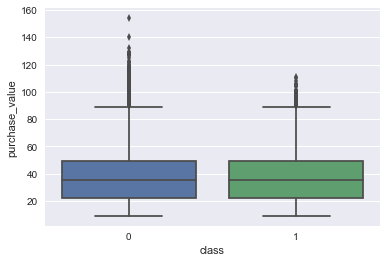

In [278]:
sns.boxplot(x=fraud_data_updated['class'],y=fraud_data_updated.purchase_value)

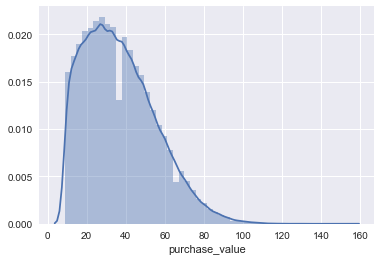

In [279]:
sns.distplot(a=fraud_data_updated.purchase_value)

In [280]:
new_set = fraud_data_updated[fraud_data_updated['class']==1]

In [281]:
new_set.purchase_value.mean()

36.993004027983886

In [282]:
new_set_two = fraud_data_updated[fraud_data_updated['class']==0]

In [283]:
new_set_two.purchase_value.mean()

36.92941786347939

In [284]:
'''As seen above mean of purchase value does not differ for different Class value ,
so it seems there is no relation between purchase value and Class,we will confirm it with Chi square test
For this we will convert Purchase value to categorical value'''

'As seen above mean of purchase value does not differ for different Class value ,\nso it seems there is no relation between purchase value and Class,we will confirm it with Chi square test\nFor this we will convert Purchase value to categorical value'

In [285]:
purchase_value_cat = []
purchase_value_mean = fraud_data_updated.purchase_value.mean()
for i in range(len(fraud_data_updated.purchase_value)):
    if fraud_data_updated.loc[i,'purchase_value'] >= purchase_value_mean:
        purchase_value_cat.append('High')
    else:
        purchase_value_cat.append('Low')
fraud_data_updated['purchase_value_cat'] = purchase_value_cat

In [286]:
crosstab = pd.crosstab(fraud_data_updated['purchase_value_cat'],fraud_data_updated['class'])

In [287]:
from scipy import stats

In [288]:
stats.chi2_contingency(crosstab)

(1.6515011727893059,
 0.19875473655588041,
 1,
 array([[ 63326.06350919,   6542.93649081],
        [ 73634.93649081,   7608.06350919]]))

In [289]:
crosstab

class,0,1
purchase_value_cat,,
High,63253,6616
Low,73708,7535


In [290]:
'''It is observed that although p value is not low,we will still keep purchase value column and maybe remove it if required after
validation testing'''

'It is observed that although p value is not low,we will still keep purchase value column and maybe remove it if required after\nvalidation testing'

In [291]:
fraud_data_updated = fraud_data_updated.drop('purchase_value_cat',axis=1)

In [292]:
fraud_data_updated.head()

,purchase_value,source,browser,sex,age,class,country,time_spent
0,34,SEO,Chrome,M,39,0,Japan,0.434673
1,16,Ads,Chrome,F,53,0,United States,0.001731
2,15,SEO,Opera,M,53,1,United States,0.000000
3,44,SEO,Safari,M,41,0,NaN,0.047462
4,39,Ads,Safari,M,45,0,United States,0.420667


In [293]:
#Finding Correlation: Source vs Class

In [294]:
crosstab = pd.crosstab(fraud_data_updated['source'],fraud_data_updated['class'])

In [295]:
crosstab

class,0,1
source,,
Ads,54368,5513
Direct,27390,3226
SEO,55203,5412


In [296]:
stats.chi2_contingency(crosstab)

(64.923177072625691,
 7.9819908364401429e-15,
 2,
 array([[ 54273.39748663,   5607.60251337],
        [ 27748.94102388,   2867.05897612],
        [ 54938.66148949,   5676.33851051]]))

In [297]:
'''so low p value(second value 7.98) clearly indicates strong correlation between Source and class'''

'so low p value(second value 7.98) clearly indicates strong correlation between Source and class'

In [298]:
fraud_data_updated.head()

,purchase_value,source,browser,sex,age,class,country,time_spent
0,34,SEO,Chrome,M,39,0,Japan,0.434673
1,16,Ads,Chrome,F,53,0,United States,0.001731
2,15,SEO,Opera,M,53,1,United States,0.000000
3,44,SEO,Safari,M,41,0,NaN,0.047462
4,39,Ads,Safari,M,45,0,United States,0.420667


In [299]:
#Finding Correlation: browser vs Class

In [300]:
crosstab = pd.crosstab(fraud_data_updated['browser'],fraud_data_updated['class'])

In [301]:
crosstab  

class,0,1
browser,,
Chrome,55363,6069
FireFox,22268,2342
IE,33540,3187
Opera,3348,328
Safari,22442,2225


In [302]:
stats.chi2_contingency(crosstab)

(44.556571734650184,
 4.9160283503647593e-09,
 4,
 array([[ 55679.15289322,   5752.84710678],
        [ 22305.37753454,   2304.62246546],
        [ 33287.67170708,   3439.32829292],
        [  3331.75813966,    344.24186034],
        [ 22357.0397255 ,   2309.9602745 ]]))

In [303]:
'''so low p value(second value) clearly indicates strong correlation between browser and class'''

'so low p value(second value) clearly indicates strong correlation between browser and class'

In [304]:
fraud_data_updated.head()

,purchase_value,source,browser,sex,age,class,country,time_spent
0,34,SEO,Chrome,M,39,0,Japan,0.434673
1,16,Ads,Chrome,F,53,0,United States,0.001731
2,15,SEO,Opera,M,53,1,United States,0.000000
3,44,SEO,Safari,M,41,0,NaN,0.047462
4,39,Ads,Safari,M,45,0,United States,0.420667


In [305]:
#Finding Correlation: sex vs Class

In [306]:
crosstab = pd.crosstab(fraud_data_updated['sex'],fraud_data_updated['class'])

In [307]:
crosstab

class,0,1
sex,,
F,57102,5717
M,79859,8434


In [308]:
stats.chi2_contingency(crosstab)

(8.7638163200416592,
 0.003072654263243465,
 1,
 array([[ 56936.26620652,   5882.73379348],
        [ 80024.73379348,   8268.26620652]]))

In [309]:
'''so low p value(second value) clearly indicates strong correlation between sex and class'''

'so low p value(second value) clearly indicates strong correlation between sex and class'

In [310]:
fraud_data_updated.head()

,purchase_value,source,browser,sex,age,class,country,time_spent
0,34,SEO,Chrome,M,39,0,Japan,0.434673
1,16,Ads,Chrome,F,53,0,United States,0.001731
2,15,SEO,Opera,M,53,1,United States,0.000000
3,44,SEO,Safari,M,41,0,NaN,0.047462
4,39,Ads,Safari,M,45,0,United States,0.420667


In [311]:
#Finding Correlation: country vs Class

In [312]:
fraud_data_updated.country.isna().sum()

21966

In [313]:
'''Earlier we were unable to identify country for so many rows from IP address,but we can not simply ignore 
these NA values in country.It might me the case that user is accessing from unknown/fraudent IP address,So we will
create new Country/Category for these users as UNKNOWN'''

'Earlier we were unable to identify country for so many rows from IP address,but we can not simply ignore \nthese NA values in country.It might me the case that user is accessing from unknown/fraudent IP address,So we will\ncreate new Country/Category for these users as UNKNOWN'

In [314]:
fraud_data_updated['country'] = fraud_data_updated.country.fillna('Unknown')

In [315]:
fraud_data_updated.head()

,purchase_value,source,browser,sex,age,class,country,time_spent
0,34,SEO,Chrome,M,39,0,Japan,0.434673
1,16,Ads,Chrome,F,53,0,United States,0.001731
2,15,SEO,Opera,M,53,1,United States,0.000000
3,44,SEO,Safari,M,41,0,Unknown,0.047462
4,39,Ads,Safari,M,45,0,United States,0.420667


In [316]:
crosstab = pd.crosstab(fraud_data_updated['country'],fraud_data_updated['class'])

In [317]:
crosstab

class,0,1
country,,
Afghanistan,5,1
Albania,13,0
Algeria,109,13
Angola,23,1
Antigua and Barbuda,3,0
Argentina,595,66
Armenia,13,2
Australia,1679,165
Austria,402,33


In [318]:
stats.chi2_contingency(crosstab)

(864.79366986788057,
 1.0717772484166951e-89,
 181,
 array([[  5.43812536e+00,   5.61874636e-01],
        [  1.17826050e+01,   1.21739504e+00],
        [  1.10575216e+02,   1.14247843e+01],
        [  2.17525015e+01,   2.24749854e+00],
        [  2.71906268e+00,   2.80937318e-01],
        [  5.99100144e+02,   6.18998557e+01],
        [  1.35953134e+01,   1.40468659e+00],
        [  1.67131720e+03,   1.72682805e+02],
        [  3.94264089e+02,   4.07359111e+01],
        [  2.08461472e+01,   2.15385277e+00],
        [  3.62541691e+00,   3.74583091e-01],
        [  1.26889592e+01,   1.31104082e+00],
        [  3.35351064e+01,   3.46489359e+00],
        [  8.15718805e+00,   8.42811954e-01],
        [  6.52575044e+01,   6.74249563e+00],
        [  3.70698879e+02,   3.83011210e+01],
        [  6.34447959e+00,   6.55520409e-01],
        [  1.81270845e+00,   1.87291545e-01],
        [  1.81270845e+00,   1.87291545e-01],
        [  1.81270845e+00,   1.87291545e-01],
        [  4.80367740e+01,  

In [319]:
'''so low p value(second value) clearly indicates strong correlation between sex and class'''

'so low p value(second value) clearly indicates strong correlation between sex and class'

In [320]:
fraud_data_updated.head()

,purchase_value,source,browser,sex,age,class,country,time_spent
0,34,SEO,Chrome,M,39,0,Japan,0.434673
1,16,Ads,Chrome,F,53,0,United States,0.001731
2,15,SEO,Opera,M,53,1,United States,0.000000
3,44,SEO,Safari,M,41,0,Unknown,0.047462
4,39,Ads,Safari,M,45,0,United States,0.420667


In [321]:
#Encode categorical features

In [322]:
source_dummy = pd.get_dummies(fraud_data_updated['source'])
fraud_data_updated = pd.concat([fraud_data_updated,source_dummy],axis=1)


In [323]:
browser_dummy = pd.get_dummies(fraud_data_updated['browser'])
fraud_data_updated = pd.concat([fraud_data_updated,browser_dummy],axis=1)

In [324]:
sex_dummy = pd.get_dummies(fraud_data_updated['sex'])
fraud_data_updated = pd.concat([fraud_data_updated,sex_dummy],axis=1)

In [325]:
country_dummy = pd.get_dummies(fraud_data_updated['country'])
fraud_data_updated = pd.concat([fraud_data_updated,country_dummy],axis=1)

In [326]:
fraud_data_updated = fraud_data_updated.drop(['sex','browser','source','country'],axis=1)

In [327]:
fraud_data_updated.head()

,purchase_value,age,class,time_spent,Ads,Direct,SEO,Chrome,FireFox,IE,...,Unknown,Uruguay,Uzbekistan,Vanuatu,Venezuela,Viet Nam,Virgin Islands (U.S.),Yemen,Zambia,Zimbabwe
0,34,39,0,0.434673,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,16,53,0,0.001731,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,15,53,1,0.000000,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,44,41,0,0.047462,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,39,45,0,0.420667,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [328]:
fraud_data_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Columns: 196 entries, purchase_value to Zimbabwe
dtypes: float64(1), int64(3), uint8(192)
memory usage: 32.3 MB


In [329]:
fraud_data_updated.shape

(151112, 196)

In [330]:
pickle.dump((fraud_data_updated),open('preprocess2.p', 'wb'))
#fraud_data_updated = pickle.load(open('preprocess_second.p', mode='rb'))

In [331]:
feature_columns = fraud_data_updated.columns.values

In [333]:
feature_columns

array(['purchase_value', 'age', 'class', 'time_spent', 'Ads', 'Direct',
       'SEO', 'Chrome', 'FireFox', 'IE', 'Opera', 'Safari', 'F', 'M',
       'Afghanistan', 'Albania', 'Algeria', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda',
       'Bhutan', 'Bolivia', 'Bonaire; Sint Eustatius; Saba',
       'Bosnia and Herzegowina', 'Botswana', 'Brazil',
       'British Indian Ocean Territory', 'Brunei Darussalam', 'Bulgaria',
       'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada',
       'Cape Verde', 'Cayman Islands', 'Chile', 'China', 'Colombia',
       'Congo', 'Congo The Democratic Republic of The', 'Costa Rica',
       "Cote D'ivoire", 'Croatia (LOCAL Name: Hrvatska)', 'Cuba',
       'Curacao', 'Cyprus', 'Czech Republic', 'Denmark', 'Djibouti',
       'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El S

### Create features and target

In [335]:
target = np.array(fraud_data_updated['class'])
features = np.array(fraud_data_updated.drop(['class'],axis=1))

In [336]:
target.shape

(151112,)

In [337]:
#target = target.reshape(-1,1)

In [338]:
target.shape

(151112,)

In [339]:
features.shape

(151112, 195)

In [2]:
import pickle
#pickle.dump((features,target),open('preprocess_data.p', 'wb'))
features,target= pickle.load(open('preprocess_data.p', mode='rb'))

### Create training and test set

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit
splitObject = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)

for train_index, test_index in splitObject.split(features, target):
    X_train, X_test = features[train_index], features[test_index] 
    y_train, y_test = target[train_index], target[test_index]

### Create Models

We will try following models and then choose the best model by comparing cross validation accuracy,then fine tune the model<br>
1.Logistic regression <br>
2.KNN<br>
3.SGD Classifier<br>
4.Random Forest




In [7]:
#1 Logistic Regression

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix,classification_report,recall_score

In [9]:
lg_model = LogisticRegression()
lg_model.fit(X_train,y_train)
lg_y_pred = lg_model.predict(X_train)

In [10]:
confusion_matrix(y_train,lg_y_pred)

array([[109560,      8],
       [ 11236,     85]], dtype=int64)

Recall is more important than precision,as we want to have very less false negative

In [12]:
print(cross_val_score(lg_model,X_train,y_train,cv=3,scoring='recall'))

[ 0.00344462  0.00132485  0.00556586]


In [13]:
print(classification_report(y_train, lg_y_pred))


             precision    recall  f1-score   support

          0       0.91      1.00      0.95    109568
          1       0.91      0.01      0.01     11321

avg / total       0.91      0.91      0.86    120889



In [14]:
lg_model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [15]:
# 2 KNN

In [16]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier()
knn_model.fit(X_train,y_train)
knn_y_pred = knn_model.predict(X_train)

In [17]:
confusion_matrix(y_train,knn_y_pred)

array([[108190,   1378],
       [  5056,   6265]], dtype=int64)

In [18]:
print(cross_val_score(knn_model,X_train,y_train,cv=3,scoring='recall'))

[ 0.49841017  0.51033386  0.51046912]


In [21]:
# 3 SGD Classifier

In [30]:
from sklearn.linear_model import SGDClassifier
sgd_model = SGDClassifier()
sgd_model.fit(X_train,y_train)
sgm_y_pred = sgd_model.predict(X_train)

C:\Users\Vani\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [31]:
confusion_matrix(y_train,sgm_y_pred)

array([[86421, 23147],
       [ 4146,  7175]], dtype=int64)

In [32]:
print(cross_val_score(sgd_model,X_train,y_train,cv=3,scoring='recall'))

[ 0.  0.  0.]


In [33]:
# 4 Random Forest

In [34]:
from sklearn.ensemble import RandomForestClassifier

In [35]:
forest_model = RandomForestClassifier()
forest_model.fit(X_train,y_train)
forest_y_pred = forest_model.predict(X_train)

In [36]:
confusion_matrix(y_train,forest_y_pred)

array([[109566,      2],
       [  1273,  10048]], dtype=int64)

In [37]:
print(cross_val_score(forest_model,X_train,y_train,cv=3,scoring='recall'))

[ 0.52782194  0.54954955  0.54412934]


It can be seen as RandomForest works best,we can optimize it further by finding tuning parameteres

### Model Tuning

In [38]:
forest_model = RandomForestClassifier()
forest_model.fit(X_train,y_train)
print(cross_val_score(forest_model,X_train,y_train,cv=3,scoring='recall'))

[ 0.52808691  0.54981452  0.54412934]


In [39]:
forest_model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Let's find tuning parameter through grid search

In [42]:
from sklearn.model_selection import GridSearchCV

In [44]:
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]
grid_search = GridSearchCV(forest_model,param_grid=param_grid,cv=5)

In [45]:
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [48]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=8, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [46]:
tuned_forest_model = grid_search.best_estimator_

In [47]:
print(cross_val_score(tuned_forest_model,X_train,y_train,cv=3,scoring='recall'))

[ 0.527292   0.5508744  0.5438643]


In [50]:
y_pred = tuned_forest_model.predict(X_test)
confusion_matrix(y_test,y_pred)

array([[27357,    36],
       [ 1337,  1493]], dtype=int64)

In [51]:
from sklearn.metrics import recall_score
recall_score(y_test, y_pred, average='binary')

0.52756183745583041

Now model is tuned but still we can try ensemble learning model

### Ensemble Techniques
1.Voting<br>
2.Bagging<br>
3.Boosting

In [59]:
# 1.Voting 
'''Let us use classifiers created above'''
from sklearn.ensemble import VotingClassifier
models = [lg_model,knn_model,forest_model]
voting = VotingClassifier(estimators=[('lg', lg_model), ('knn', knn_model), ('forest',forest_model)],voting='hard')
voting.fit(X_train,y_train)
y_pred = voting.predict(X_test)
recall_score(y_test, y_pred, average='binary')
 

0.52332155477031805

In [61]:
#2.Bagging
'''We have already used one bagging algorithm i.e RandomForest,so let us use different bagging algo'''
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
bagging = BaggingClassifier(base_estimator=dt)
bagging.fit(X_train,y_train)
y_pred = bagging.predict(X_test)
recall_score(y_test, y_pred, average='binary')

0.52720848056537106

In [62]:
#Boosting
'''AdaBoost'''
from sklearn.ensemble import AdaBoostClassifier
ada_boost = AdaBoostClassifier()
ada_boost.fit(X_train,y_train)
y_pred = ada_boost.predict(X_test)
recall_score(y_test, y_pred, average='binary')

0.52685512367491161

In [63]:
'''Gradient Boosting machine'''
from sklearn.ensemble import GradientBoostingClassifier
grad_boost = GradientBoostingClassifier()
grad_boost.fit(X_train,y_train)
y_pred = grad_boost.predict(X_test)
recall_score(y_test, y_pred, average='binary')

0.52685512367491161

In [65]:
'''xgboost,lightboost not part of sklearn'''
#import xgboost as xgb
#xg_boost=xgb.XGBClassifier(learning_rate=0.01)

'xgboost,lightboost not part of sklearn'

### Precision-Recall Curve

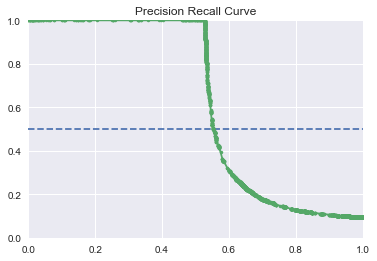

In [73]:
from sklearn.metrics import precision_recall_curve
probs = grad_boost.predict_proba(X_test)
preds = probs[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)

plt.title('Precision Recall Curve')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
plt.plot(recall, precision, marker='.')

### ROC curve

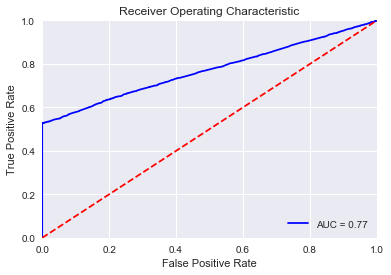

In [68]:
from sklearn.metrics import roc_curve,auc
probs = grad_boost.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()